##### Sensitivity Analysis Results (Simulation are done in [SensAnalysisP0100&Pbt](SensAnalysisP0100&Pbt.ipynb) )

with variation of :
- Controlled Energy Producer Maximum output 
- Total Bt Production (global BT energy producer in the higuer level network)


Maximum voltage rise $vm_{pu}^{max} = 1.0250 $

---

#### Import Modules 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pickle, sys, importlib
import joblib
import dill 
import os
from scipy import ndimage

# Ignore all the warning
import warnings
warnings.filterwarnings( "ignore")

##### My own modules and functions

In [2]:
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
import oriClass as oriCs
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list 
from oriFunctions import testSet_end_date, testSet_start_date

#### Import Simulation results from Simumlation done in [SensAnalysisP0100&Pbt](SensAnalysisP0100&Pbt.ipynb)

In [3]:
persFolder = 'pickle_files/simulationResults/SensAnalysis/Pers2/' # Folder name
futureKnownFolder = 'pickle_files/simulationResults/SensAnalysis/FutureKnown2/'
noConctrolFolder = 'pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/' 
rnnFolder = 'pickle_files/simulationResults/SensAnalysis/RNNRob/' 

#***************************** Use to rename files wrongly named -************************
# for older_name in [elm for elm in os.listdir(futureKnownFolder) if elm.endswith('.plk')]:
#     w_name1, wname2, btrange, numExtenxion = older_name.split('_')
#     new_name = w_name1+wname2+'_'+btrange+'_'+numExtenxion
#     source = futureKnownFolder+older_name
#     destination = futureKnownFolder+new_name
#     os.rename(source, destination)

#### Load data 

In [4]:
df_data = joblib.load(network_folder+'CleanedData.pkl')


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('07:00','18:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = df_data.loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[(df_data.index>='2021 06 01') & (df_data.index<=testSet_end_date)]
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time('07:00','18:50') ).index.to_period('10T')

df_final_copy = df_final.copy(deep=True)

## Unique Model Sensitivity Analysis

#### Initiate folders with the SensAnalysis Class

In [5]:
persistence, knownFuture, rnn_rob = map(oriCs.SensAnlysisResult, [persFolder, futureKnownFolder, rnnFolder])

#### Extract and Transform the results in datafra

In [6]:
persistence.in_dataFrame(testSet_start_date, testSet_end_date)
knownFuture.in_dataFrame(testSet_start_date, testSet_end_date)
rnn_rob.in_dataFrame(testSet_start_date, testSet_end_date);

#### Plot Future known Sens analysis

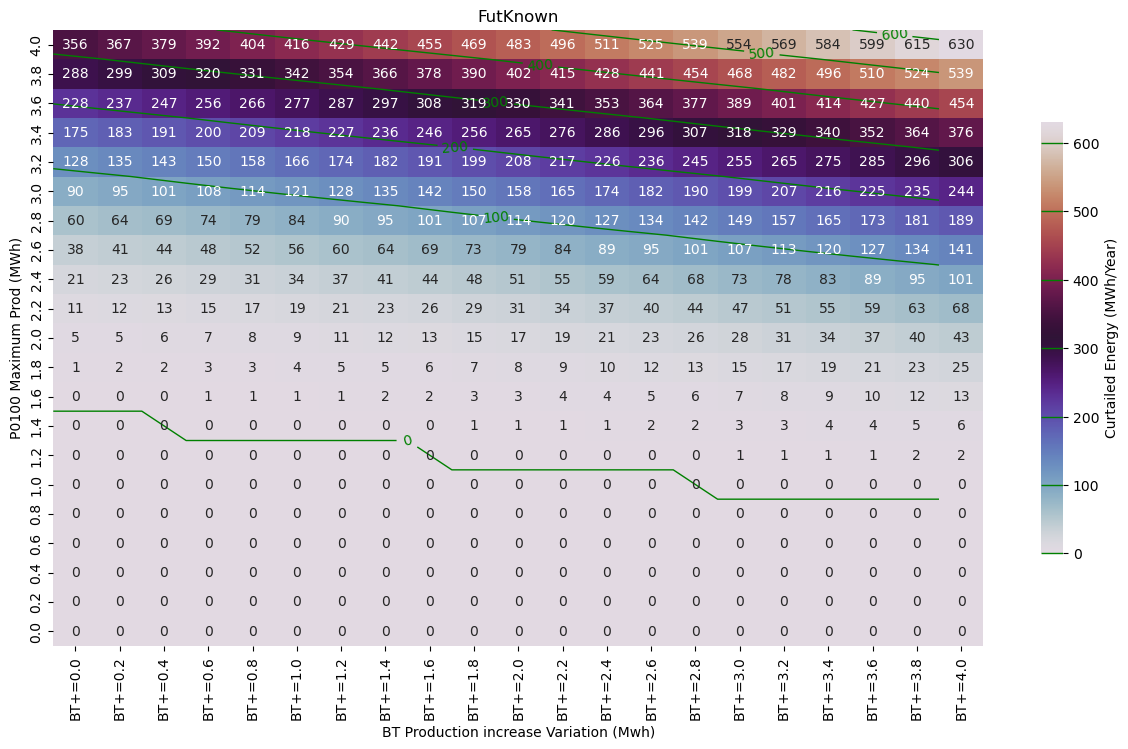

In [7]:
fig, axx = plt.subplots(1,1, figsize=(15,8), sharey=True, dpi= 100)

knownFuture_contour = knownFuture.plot_heatmap(fig_params=axx, 
                                        show_ylabel=True, 
                                        anotation=True,
                                        contour_color='green',
                                        show_contour=True)


### Plot Robust Persistence Sens analysis

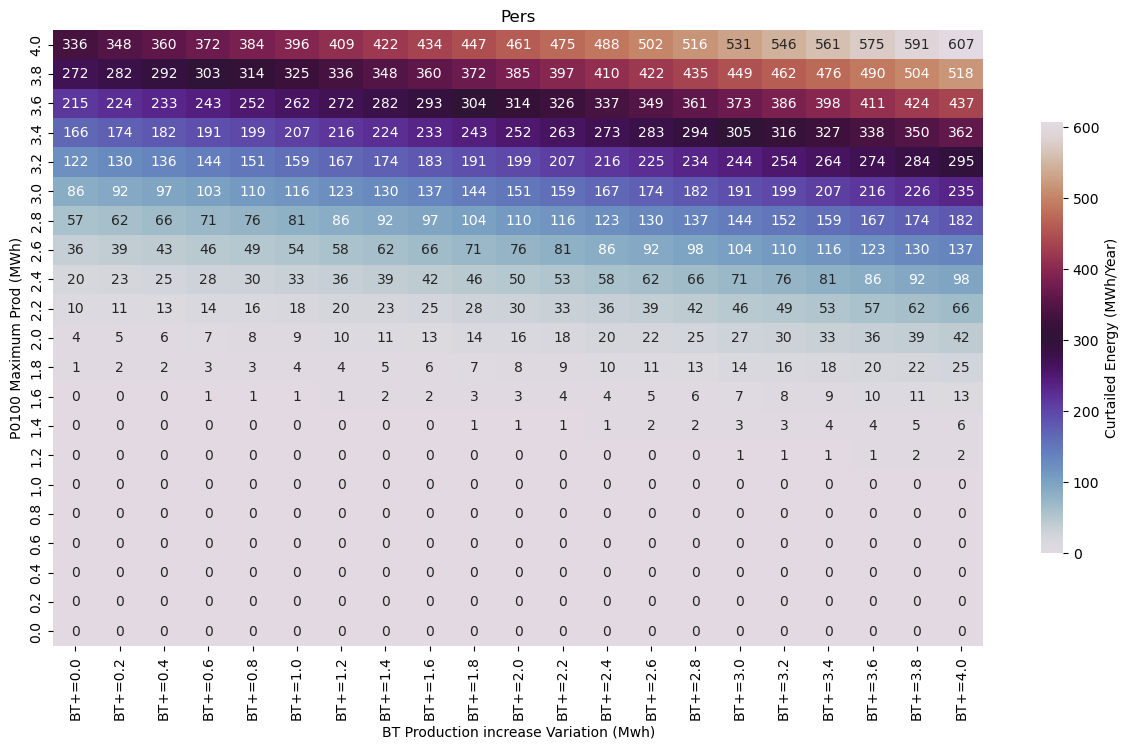

In [8]:
fig, axx = plt.subplots(1,1, figsize=(15,8), sharey=True, dpi= 100)

pers_contour = persistence.plot_heatmap(fig_params=axx, 
                                        show_ylabel=True, 
                                        anotation=True, 
                                        show_contour=False)


### Plot RNN Sens analysis

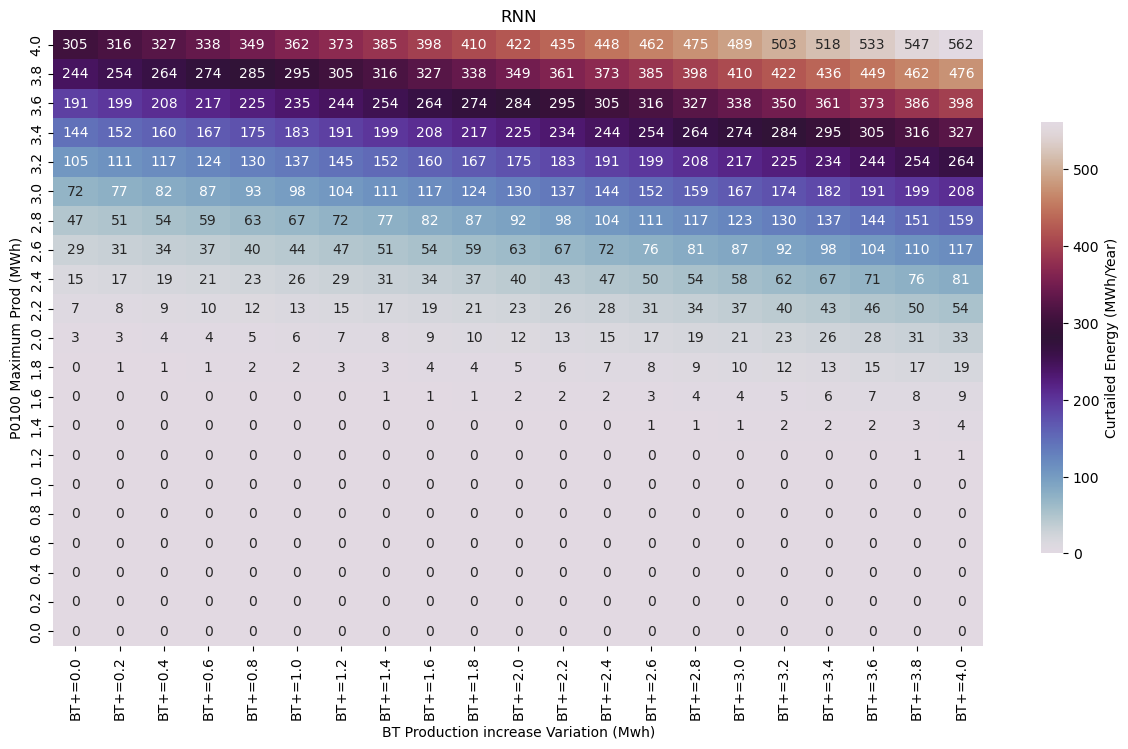

In [9]:
fig, axx = plt.subplots(1,1, figsize=(15,8), sharey=True, dpi= 100)

rnn_contour = rnn_rob.plot_heatmap(fig_params=axx, 
                                   show_ylabel=True, 
                                   anotation=True,
                                   contour_color='red', 
                                   show_contour=False
                                  )


### All the previous together

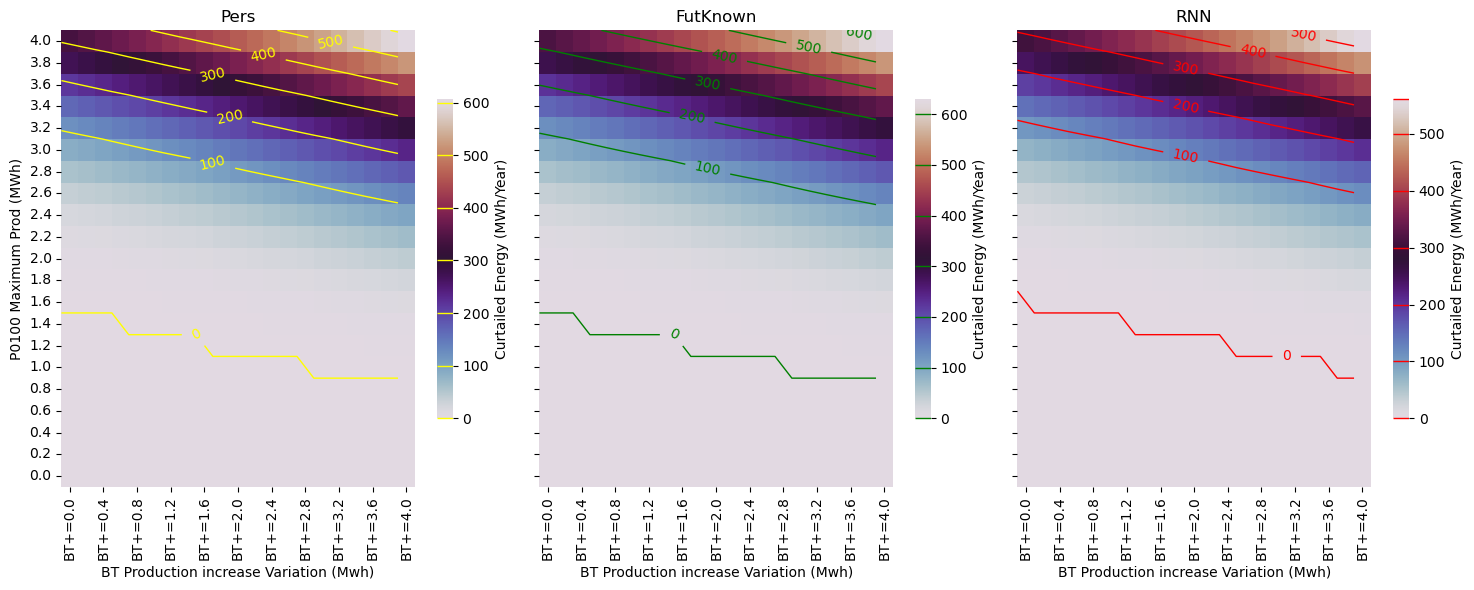

In [10]:
fig, axx = plt.subplots(1,3, figsize=(15,6), sharey=True)
pers_contour = persistence.plot_heatmap(fig_params=axx[0], show_ylabel=True,)
futknown_contour = knownFuture.plot_heatmap(fig_params=axx[1], contour_color='green')
rnn_contour = rnn_rob.plot_heatmap(fig_params=axx[2],contour_color='red')
fig.tight_layout()

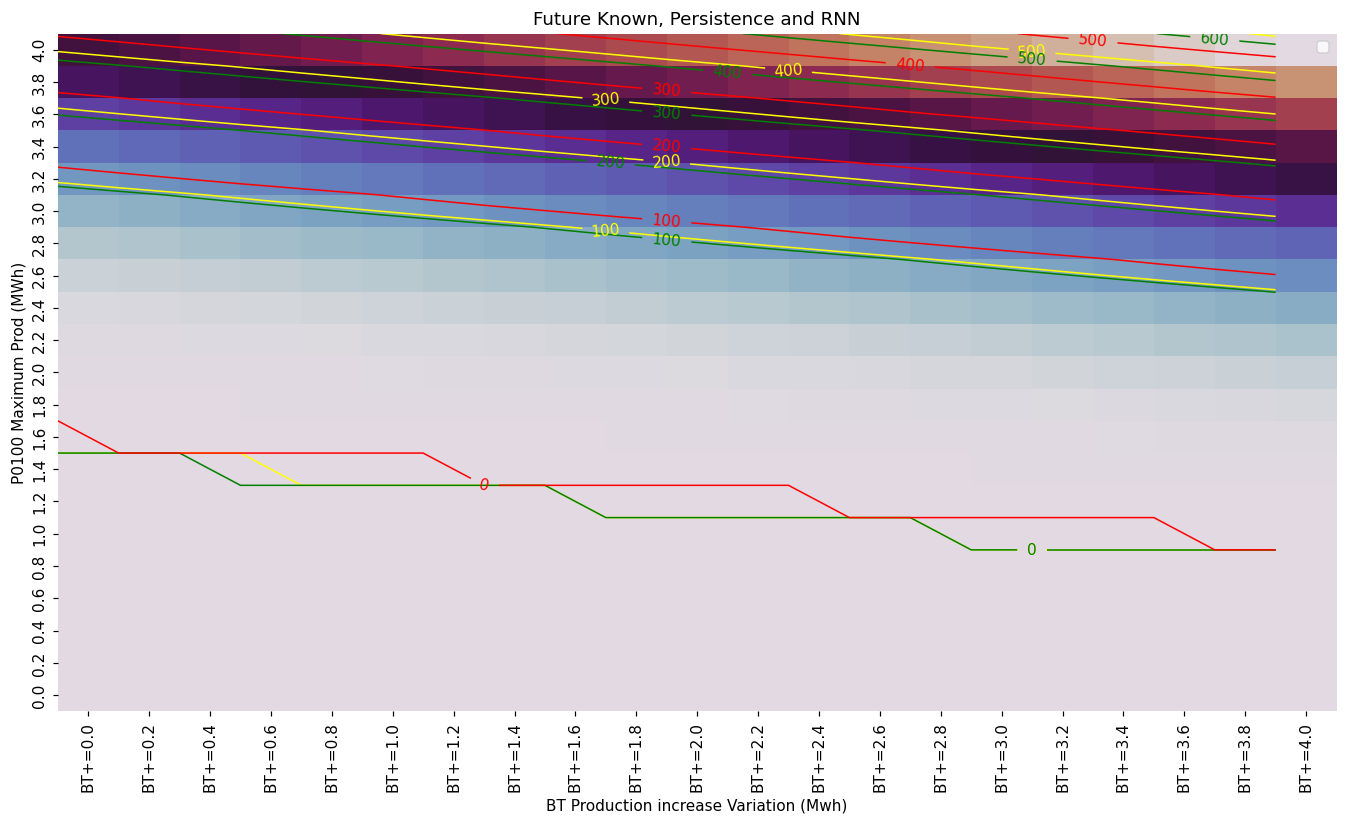

In [11]:
fig, axx = plt.subplots(1,1, figsize=(15,8), sharey=True,dpi=110)
pers_contour = persistence.plot_heatmap(fig_params=axx, show_cbar=False)
futknown_contour = knownFuture.plot_heatmap(fig_params=axx,contour_color='green', show_cbar=False)
rnn_contour = rnn_rob.plot_heatmap(fig_params=axx,contour_color='red', show_cbar=False, show_ylabel=True)
axx.legend([pers_contour,futknown_contour, futknown_contour])
axx.set(title = "Future Known, Persistence and RNN");

---

## Mixed Sens Analysis

In [13]:
P0100_max = 4.
bt_add_max =4. 

P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2).round(decimals=2)
bt_add_max_range = np.arange(0, bt_add_max+0.1, 0.2).round(decimals=2)

persRnnNoControlFutKnown = oriCs.SensAnlysisResults([persFolder, rnnFolder, noConctrolFolder,futureKnownFolder],
                                                    ['PersRob','RnnRob', 'Nocontrol', 'FutureKnown'], 
                                                    (testSet_start_date,testSet_end_date), 
                                                    (P0100_max_range, bt_add_max_range) 
                                                   )

#### Defining some terms
##### 'v_rise' count
> Represents the total number of voltage rises that occurs above the defined threshold in reality on the network (i.e. output of the last bloc in both VoltageRise detection Schemes

##### 'Capping' count
>Represents the total number of capping commands sent the energy producer to curtail its production

In the best case scenario where the future is perfectly known << 'v_rise' count >> equals <<'capping' count>> as one can see in the following plots. 

In the other cases, since the predcition model is not perfect, the energy producer's energy curtailement does not result in no voltage rise occuring on the network. THe closer the controller point is to the Future known, the better it is

#### Plot voltage rise Box plot of a particular element

The collumn ['Power Sgen'] is not present in files located in pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/


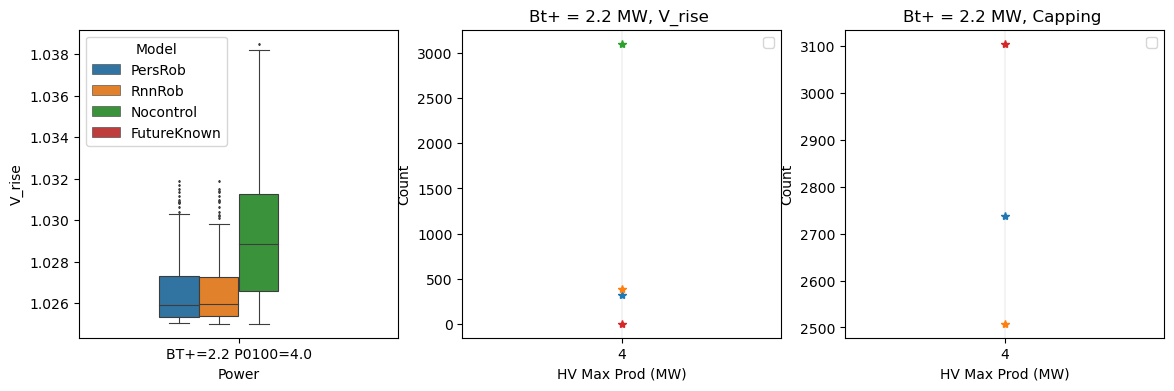

In [14]:
fig, axx= plt.subplots(1,3, figsize=(14,4))
ht_, bt_ = 4., 2.2   
persRnnNoControlFutKnown.vRise_boxplot(ht=ht_, bt=bt_, fig_params=axx[0]);
persRnnNoControlFutKnown.countplot('v_rise', fig_params=axx[1])
persRnnNoControlFutKnown.countplot('capping', fig_params=axx[2])


#### Plot voltage rise Box plot of a several element

The collumn ['Power Sgen'] is not present in files located in pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/
The collumn ['Power Sgen'] is not present in files located in pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/
The collumn ['Power Sgen'] is not present in files located in pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/
The collumn ['Power Sgen'] is not present in files located in pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/
The collumn ['Power Sgen'] is not present in files located in pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/


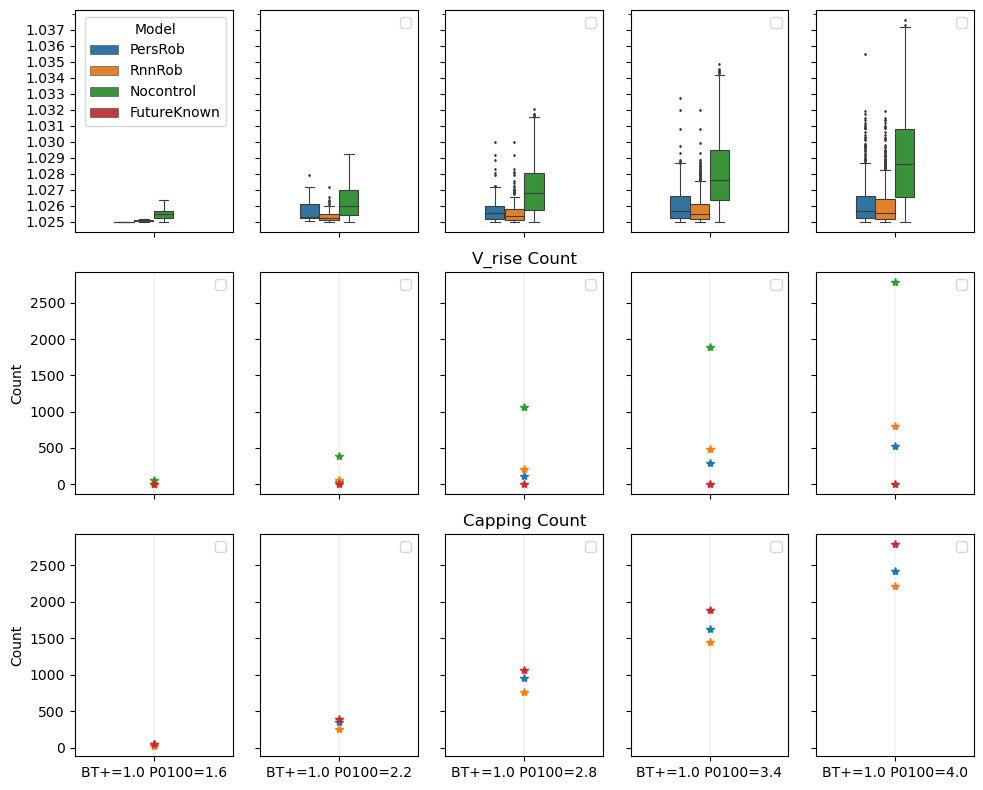

In [15]:
ht_elm = [1.6, 2.2, 2.8, 3.4, 4.] # Define elem to plot

ticks_ = np.arange(1.025,1.037,0.001)

fig, axx= plt.subplots(3,len(ht_elm), figsize=(10,8), sharey='row', dpi=100)

for ax_index, cur_ht in enumerate(ht_elm):  
    persRnnNoControlFutKnown.vRise_boxplot(cur_ht, 1., fig_params=axx[0,ax_index])
    persRnnNoControlFutKnown.countplot('v_rise',fig_params=axx[1,ax_index])
    persRnnNoControlFutKnown.countplot('capping', fig_params=axx[2,ax_index])
    axx[0,ax_index].set(ylabel='')
    axx[0,ax_index].set(xlabel='')
    

for elm in axx[0,1:]: elm.legend(['_','_'])
# for elm in axx[0,:-2]: elm.set(ylabel='')
for elm0, elm1, elm2 in zip(range(len(ht_elm)), axx[1,:], axx[2,:]): 
    elm1.set(title='', xlabel='')    
   
    elm1.set_xticks(elm1.get_xticks(), labels='')
    elm2.set(title='', xlabel='')
    elm2.set_xticks(elm2.get_xticks(),
                    labels= axx[0,elm0].get_xticklabels())
    
    
    axx[0, elm0].set_xticks(axx[0, elm0].get_xticks(), labels='')
    
axx[2,2].set(title='Capping Count')
axx[1,2].set(title='V_rise Count')
axx[0,0].set_yticks(ticks_)
fig.tight_layout()

#### Plot voltage rise Box plot for all element of a particular BT

The collumn ['Power Sgen'] is not present in files located in pickle_files/simulationResults/SensAnalysis/FutureKnownNoControl/


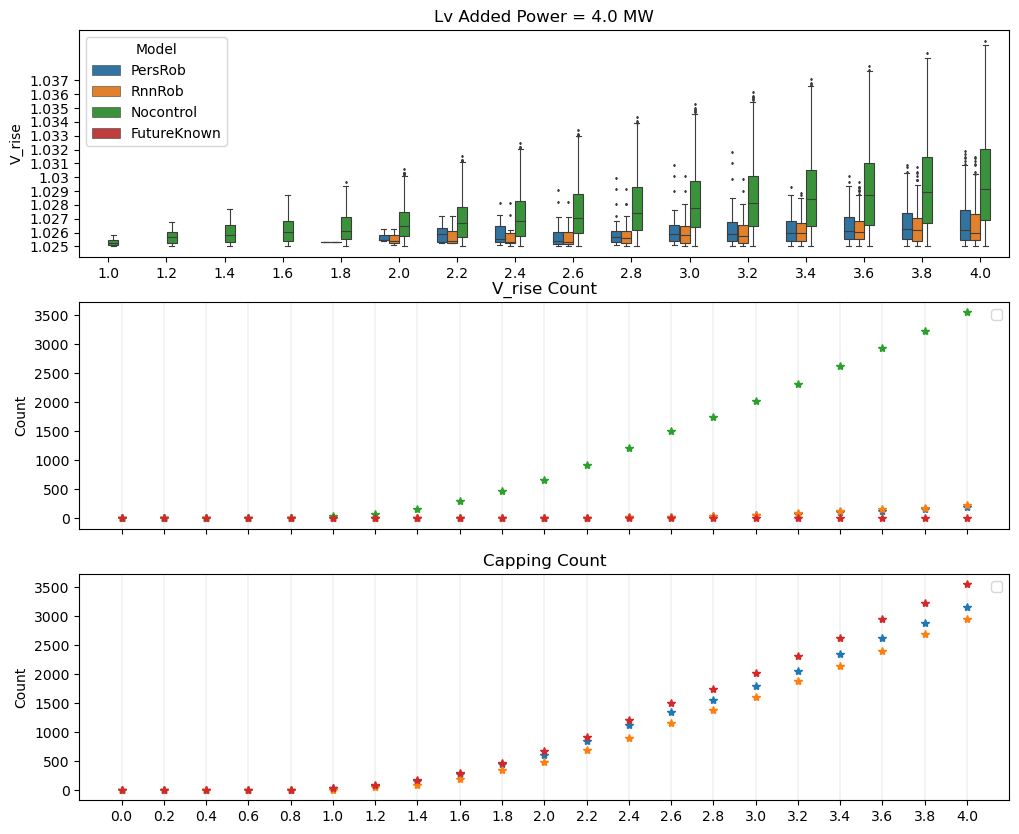

In [19]:
fig, axx = plt.subplots(3,1, figsize=(12,10))
persRnnNoControlFutKnown.vRise_boxplot(ht='All', bt=4., fig_params=axx[0])
persRnnNoControlFutKnown.countplot('v_rise',fig_params=axx[1])
persRnnNoControlFutKnown.countplot('capping',fig_params=axx[2])
for elm in axx: elm.set(xlabel='')
axx[1].set(title='V_rise Count')
axx[2].set(title='Capping Count')
axx[1].set_xticks(axx[1].get_xticks(), labels='');